In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [23]:
animal_meta_all = {
    325: {
        'ephys_raw_path_experiment'  : r'D:\KH-BIOE504_project\325_10012020\run1\ephys_g0',
        'ephys_raw_path_postfix'     : '.nidq.bin',
        'KS_output_path'             : r'D:\KH-BIOE504_project\325_10012020\run1\KS2',
        'behavior_csv_path'          : r'D:\KH-BIOE504_project\325_10012020\run1\processed\behavior.csv',
        'ephys_start_trial'          : [0],
        'ephys_stop_trial'           : [499]
    }
}

In [47]:
# Main functions

def get_spiking_time(spikes, idx):
    # Get the spiking for this unit
    return spikes[spikes[:, 0] == idx, 1]


def load_meta_behavior_from_group(animal_meta_all):
    # behavioral_path: a list of directories to the behavior.csv
    # return a data frame contains the first row of each trial
    animal_id_range = list(animal_meta_all.keys())
    for animal_id in animal_id_range:
        animal_meta = animal_meta_all[animal_id]
        behavior_distinct_curr = load_meta_behavior(animal_meta['behavior_csv_path'], animal_id)
        if 'behavior_distinct' not in locals():
            behavior_distinct = behavior_distinct_curr
        else:
            behavior_distinct = pd.concat([behavior_distinct, behavior_distinct_curr])
    return behavior_distinct


def load_spiking_from_group(animal_meta_all):
    # path_all: a list of directories to the KiloSort output folders
    # animal_id_range: a list of animal ID
    # return a 2D NumPy array, which including templete indexes, spiking timing w.r.t. the global time
    # and amplitudes of the spikes
    animal_id_range = list(animal_meta_all.keys())
    for animal_id in animal_id_range:
        animal_meta = animal_meta_all[animal_id]
        spikes_curr = load_spiking(animal_meta['KS_output_path'], animal_id)
        if 'spikes' not in locals():
            spikes = spikes_curr
        else:
            spikes = np.vstack([spikes, spikes_curr])
    return spikes


def load_meta_ephys_from_group(animal_meta_all, number_channel=64):
    # Read the folder of the raw ephys recording folder and extract the duration of each trial,
    # then group all the info into one data frame
    animal_id_range = list(animal_meta_all.keys())
    for animal_id in animal_id_range:
        animal_meta = animal_meta_all[animal_id]
        path_2_experiment = animal_meta['ephys_raw_path_experiment']
        path_prefix = path_2_experiment + '\\ephys_g0_t'
        path_postfix = animal_meta['ephys_raw_path_postfix']
        path_recording_all = [f for f in os.listdir(path_2_experiment) if f.endswith('.bin')]
        trial_count = len(path_recording_all)
        trials_info = load_meta_ephys(animal_id, path_prefix, path_postfix, trial_count, number_channel)
        if 'trials_info_all' not in locals():
            trials_info_all = trials_info
        else:
            trials_info_all = pd.concat([trials_info_all, trials_info])
    trials_info_all['global_trial'] = trials_info_all['trial'] + trials_info_all['animal'] * 10000
    return trials_info_all


def globalize_spike_timing_from_group(spikes, animal_meta_all, trials_info_all):
    # Initially you get the spike timing in the concatenated ephys file's global time
    # Because you cut the session, now let's put it back to the real global time
    animal_id_range = list(animal_meta_all.keys())
    for animal_id in animal_id_range:
        animal_meta = animal_meta_all[animal_id]
        ephys_start_trial = animal_meta['ephys_start_trial']
        ephys_stop_trial = animal_meta['ephys_stop_trial']
        for i in range(len(ephys_start_trial)):
            ephys_start_trial_curr = ephys_start_trial[i]
            ephys_stop_trial_curr = ephys_stop_trial[i]
            spikes_temp = globalize_spike_timing(spikes, ephys_start_trial_curr, ephys_stop_trial_curr, animal_id, trials_info_all)
            if 'spikes_final' not in locals():
                spikes_final = spikes_temp
            else:
                spikes_final = spikes_final = np.vstack([spikes_final, spikes_temp])
    return spikes_final

def build_behavior_trials(behavior_distinct, left_trial_name='OL_L_2.9', right_trial_name='OL_R_3.1'):
    # Build a unfiltered behavioral data frame which contains a global trial column (trial_id * 10000 + animal_id)
    # behavior_distinct: output data frame by load_meta_behavior_from_group
    # left_trial_name & right_trial_name: the descriptions of left and right trials
    # Return a neat behavior data frame
    beh_trials_unfiltered_R = pd.DataFrame([])
    df_curr = behavior_distinct[behavior_distinct['trial_type'] == right_trial_name]
    beh_trials_unfiltered_R['Trial Number'] = df_curr['trial']
    beh_trials_unfiltered_R['animal'] = df_curr['animal']
    beh_trials_unfiltered_R['Trial Type'] = 'Right'

    beh_trials_unfiltered = beh_trials_unfiltered_R
    beh_trials_unfiltered = beh_trials_unfiltered.sort_values(['animal', 'Trial Number']).reset_index()
    beh_trials_unfiltered['global_trial'] = beh_trials_unfiltered['Trial Number'] + beh_trials_unfiltered['animal'] * 10000
    return beh_trials_unfiltered

# Functions for directly adding columns to data frames
def add_unit_type(metrics):
    # This function takes the metrics generated from ecephys and add a column 'unit_type'
    metrics['unit_type'] = 'Inhibitory'
    metrics.loc[metrics['duration'] > 0.5, 'unit_type'] = 'Excitatory'
    metrics = metrics.sort_values(['animal', 'depth'], ascending=[True, False]).reset_index()
    return metrics

def add_spiking_time(metrics, spikes_final, trials_behavior_still_or_run, beh_trials_unfiltered):
    # Add two columns with local spiking time in left and right trials
    metrics['spiking_left_local_timing'] = metrics.apply(get_spiking_local_left, axis=1, args=(spikes_final, trials_behavior_still_or_run, beh_trials_unfiltered))
    metrics['spiking_right_local_timing'] = metrics.apply(get_spiking_local_right, args=(spikes_final, trials_behavior_still_or_run, beh_trials_unfiltered))
    return metrics

def add_global_timing(dfs_behavior, trials_info_all):
    dfs_behavior['t0_global_time_ephys_file'] = trials_info_all[trials_info_all['global_trial'].isin(dfs_behavior['global_trial'])]['trial_start_file_time'].to_list()
    dfs_behavior['tminus_global_time_ephys_file'] = trials_info_all[trials_info_all['global_trial'].isin(dfs_behavior['global_trial'] - 1)]['trial_start_file_time'].to_list()
    last = trials_info_all[trials_info_all['global_trial'].isin(dfs_behavior['global_trial'] + 1)]['trial_start_file_time'].to_list()
    if len(last) != len(dfs_behavior['tminus_global_time_ephys_file']):
        last.append(np.nan)
    dfs_behavior['tplus_global_time_ephys_file'] = last
    return dfs_behavior

# Functions for data frames to apply
def get_spiking_local(row, spikes_final, trials_behavior_still_or_run, beh_trials_unfiltered, 
                      trial_starting_time, trial_stop_time, 
                      return_mean_fr=False, return_local_spiking=False, 
                      distinguish_direction=False, direction=None, 
                      distinguish_status=False, status=None, 
                      return_matrix=False, matrix_bin=1, bin_range=[-1, 3]):
    unit = row['cluster_id_global']
    spiking_curr_unit = get_spiking_time(spikes_final, unit)
    
    if not return_matrix:
        spiking_local_curr = np.array([])
    
    if distinguish_direction and distinguish_status:
        trials = list(trials_behavior_still_or_run[(trials_behavior_still_or_run['trial_type'] == direction) & (trials_behavior_still_or_run['status'] == status)]['global_trial'].values)
    elif distinguish_direction:
        trials = list(trials_behavior_still_or_run[trials_behavior_still_or_run['trial_type'] == direction]['global_trial'].values)
    elif distinguish_status:
        trials = list(trials_behavior_still_or_run[trials_behavior_still_or_run['status'] == status]['global_trial'].values)
    else: 
        trials = list(trials_behavior_still_or_run['global_trial'].values)
        
    for trial in trials:
        df_curr = beh_trials_unfiltered[beh_trials_unfiltered['global_trial'] == trial]
        t0_curr = df_curr['t0_global_time_ephys_file'].values[0]
        tminus_curr = df_curr['tminus_global_time_ephys_file'].values[0]
        tplus_curr = df_curr['tplus_global_time_ephys_file'].values[0]
        spiking_curr_unit_trial = spiking_curr_unit[np.where((spiking_curr_unit > tminus_curr) & (spiking_curr_unit < tplus_curr))]
        spiking_curr_unit_trial = spiking_curr_unit_trial - t0_curr
        if return_matrix:
            spiking_curr_unit_trial_binned, _ = np.histogram(spiking_curr_unit_trial, bins=matrix_bin*1000*(bin_range[1]-bin_range[0]), range=bin_range)
            if 'spiking_local_curr' not in locals():
                spiking_local_curr = spiking_curr_unit_trial_binned
            else:
                spiking_local_curr = np.vstack([spiking_local_curr, spiking_curr_unit_trial_binned])
        else:
            spiking_local_curr = np.append(spiking_local_curr, spiking_curr_unit_trial)
            spiking_local_curr = np.sort(spiking_local_curr)
    
    if return_matrix:
        return spiking_local_curr, trials
    elif return_mean_fr and return_local_spiking:
        raise ValueError("Can only return one of mean FR and spiking")
    elif return_mean_fr:
        spiking_local_curr = np.sort(spiking_local_curr)
        spiking_local_curr = spiking_local_curr[np.where((spiking_local_curr >= trial_starting_time) & (spiking_local_curr <= trial_stop_time))]
        fr_local_curr = len(spiking_local_curr) / len(trials) / (trial_stop_time - trial_starting_time)
        return fr_local_curr, trials
    elif return_local_spiking:
        return spiking_local_curr, trials
    else:
        raise ValueError("Must select one of mean FR and spiking")

        
# Sub-functions. You don't have to understand
def load_meta_behavior(behavioral_path, animal_id):
    behavior_curr = pd.read_csv(behavioral_path)
    behavior_distinct_curr = behavior_curr.drop_duplicates(subset=['trial'])
    behavior_distinct_curr['animal'] = animal_id
    return behavior_distinct_curr

def load_spiking(path, animal_id):
    amplitudes = np.load(os.path.join(path, 'amplitudes.npy'))
    spike_templates = np.load(os.path.join(path, 'spike_templates.npy'))
    spike_times = np.load(os.path.join(path, 'spike_times.npy'))
    spikes_curr = np.hstack((spike_templates, spike_times, amplitudes))
    spikes_curr[:, 1] = spikes_curr[:, 1] / 25000
    spikes_curr[:, 0] = spikes_curr[:, 0] + animal_id * 1000
    return spikes_curr

def load_meta_ephys(animal_id, path_prefix, path_postfix, trial_count, dur_ITI=0, fix_ITI=True, number_channel=64):
    trials_info = pd.DataFrame()
    for i in range(trial_count):
        s = os.path.getsize(path_prefix + str(i) + path_postfix)
        duration_file_curr = s / 25000 / number_channel / 2

        behavior_curr = behavior_distinct[(behavior_distinct['animal'] == animal_id) & (behavior_distinct['trial'] == i)]

        trials_info.loc[i, 'trial'] = i
        trials_info.loc[i, 'ephys_file_duration'] = duration_file_curr
        if fix_ITI:
            trials_info.loc[i, 'ephys_file_w_ITI'] = duration_file_curr + dur_ITI
            trials_info.loc[i, 'ITI'] = dur_ITI
        else:
            trials_info.loc[i, 'ephys_file_w_ITI'] = behavior_distinct[behavior_distinct['trial'] == i]['ts_local'].values
            trials_info.loc[i, 'ITI'] = - behavior_distinct[behavior_distinct['trial'] == i]['ts_local'].values
        trials_info.loc[i, 'trial_start_beh_global_time'] = behavior_curr['ts_global'].values
        trials_info.loc[i, 'trial_type'] = behavior_curr['trial_type'].values

    trials_info['trial_start_global_time'] = 0
    trials_info['trial_start_global_time'][1:] = trials_info['ephys_file_w_ITI'].cumsum()[:-1]
    trials_info['trial_start_file_time'] = 0
    trials_info['trial_start_file_time'][1:] = trials_info['ephys_file_duration'].cumsum()[:-1]
    trials_info['animal'] = animal_id
    return trials_info

def globalize_spike_timing(spikes, ephys_start_trial, ephys_stop_trial, animal_id, trials_info_all):
    global_trial_start = animal_id * 10000 + ephys_start_trial
    global_trial_stop = animal_id * 10000 + ephys_stop_trial
    trial_curr_start = trials_info_all[trials_info_all['global_trial'] == global_trial_start]
    trial_curr_stop = trials_info_all[trials_info_all['global_trial'] == global_trial_stop]
    
    ephys_start_time = trial_curr_start['trial_start_file_time'].values[0]
    ephys_stop_time = trial_curr_stop['trial_start_file_time'].values[0] + trial_curr_stop['ephys_file_duration'].values[0]
    spikes_temp = spikes[np.where((spikes[:, 0] < (animal_id + 1) * 1000) & (spikes[:, 0] >= (animal_id) * 1000) & (spikes[:, 1] >= ephys_start_time) & (spikes[:, 1] <= ephys_stop_time))]
    spikes_temp[:, 1] = spikes_temp[:, 1] + ephys_start_time
    return spikes_temp

In [48]:
spikes = load_spiking_from_group(animal_meta_all)
behavior_distinct = load_meta_behavior_from_group(animal_meta_all)
trials_info_all = load_meta_ephys_from_group(animal_meta_all, number_channel=64)
metrics = pd.read_csv(r'D:\KH-BIOE504_project\325_10012020\run1\KS2\metrics.csv')

<ipython-input-47-dc4df51f1e54>:14: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  behavior_distinct_curr = load_meta_behavior(animal_meta['behavior_csv_path'], animal_id)
<ipython-input-47-dc4df51f1e54>:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behavior_distinct_curr['animal'] = animal_id
<ipython-input-47-dc4df51f1e54>:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials_info['trial_start_global_time'][1:] = trials_info['ephys_file_w_ITI'].cumsum()[:-1]
<ipython-input-47-dc4df51f1e54>:207: Sett

In [49]:
beh_trials_unfiltered = build_behavior_trials(behavior_distinct, left_trial_name='OL_L_2.9', right_trial_name='OL_R_8')
beh_trials_unfiltered = add_global_timing(beh_trials_unfiltered, trials_info_all)

spikes_final = globalize_spike_timing_from_group(spikes, animal_meta_all, trials_info_all)

In [59]:
trial_list = behavior_distinct[behavior_distinct['trial_type'] == 'OL_R_8']['trial'].values
dfs_behavior = pd.read_csv(r'D:\KH-BIOE504_project\325_10012020\run1\processed\behavior.csv')

C:\Users\mntl-vlasov-access\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3343: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [64]:
trials_behavior_still_or_run = pd.DataFrame({'animal': 325, 'local_trial': trial_list, 'trial_type': 'right'})
trials_behavior_still_or_run['global_trial'] = trial_list + 325 * 10000
trials_behavior_still_or_run['status'] = np.nan

for i in range(len(trial_list)):
    t = trial_list[i]
    df_curr = dfs_behavior[dfs_behavior['trial'] == t]
    speed_mean = df_curr['speed_xy'].mean()
    if speed_mean > 5:
        trials_behavior_still_or_run.loc[i, 'status'] = 'run'
    else:
        trials_behavior_still_or_run.loc[i, 'status'] = 'still'

,animal,local_trial,trial_type,global_trial,status
0,325,5.0,right,3250005.0,NaN
1,325,9.0,right,3250009.0,NaN
2,325,12.0,right,3250012.0,NaN
3,325,14.0,right,3250014.0,NaN
4,325,16.0,right,3250016.0,NaN
...,...,...,...,...,...
167,325,484.0,right,3250484.0,NaN
168,325,486.0,right,3250486.0,NaN
169,325,488.0,right,3250488.0,NaN
170,325,490.0,right,3250490.0,NaN


In [120]:
beh_trials_unfiltered.drop(['tminus_global_time_ephys_file'], axis=1).to_csv('beh_trials_unfiltered.csv')

In [122]:
trials_behavior_still_or_run.to_csv('trials_behavior_still_or_run.csv')

In [91]:
metrics_filtered = metrics[(metrics['isi_viol'] < 0.1) & (metrics['amplitude_cutoff'] < 0.5) & (metrics['firing_rate'] > 1)]
metrics_filtered['cluster_id_global'] = metrics_filtered['cluster_id'] + 325 * 1000

<ipython-input-91-804ccb9fd318>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_filtered['cluster_id_global'] = metrics_filtered['cluster_id'] + 325 * 1000


In [94]:
result_temp = metrics_filtered.apply(get_spiking_local, axis=1, result_type='expand',
                                     spikes_final=spikes_final, trials_behavior_still_or_run=trials_behavior_still_or_run, beh_trials_unfiltered=beh_trials_unfiltered, 
                                     trial_starting_time=0, trial_stop_time=7, 
                                     distinguish_direction=True, direction='right', 
                                     distinguish_status=True, status='run', 
                                     return_local_spiking=True)
metrics_filtered['spiking_right_local_timing_run'] = result_temp[0]
metrics_filtered['spiking_right_local_timing_run_trials'] = result_temp[1]

<ipython-input-94-ab7278d77a8e>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_filtered['spiking_right_local_timing_run'] = result_temp[0]
<ipython-input-94-ab7278d77a8e>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_filtered['spiking_right_local_timing_run_trials'] = result_temp[1]


"result_temp = metrics_filtered.apply(get_spiking_local, axis=1, result_type='expand',\n                                     spikes_final=spikes_final, trials_behavior_still_or_run=trials_behavior_still_or_run, beh_trials_unfiltered=beh_trials_unfiltered, \n                                     trial_starting_time=-1, trial_stop_time=3, \n                                     distinguish_direction=True, direction='left',\n                                     return_mean_fr=True)\nmetrics_filtered['fr_left_local_timing_all'] = result_temp[0]\nmetrics_filtered['fr_left_local_timing_all_trials'] = result_temp[1]\n\nresult_temp = metrics_filtered.apply(get_spiking_local, axis=1, result_type='expand',\n                                     spikes_final=spikes_final, trials_behavior_still_or_run=trials_behavior_still_or_run, beh_trials_unfiltered=beh_trials_unfiltered, \n                                     trial_starting_time=-1, trial_stop_time=3, \n                                     distin

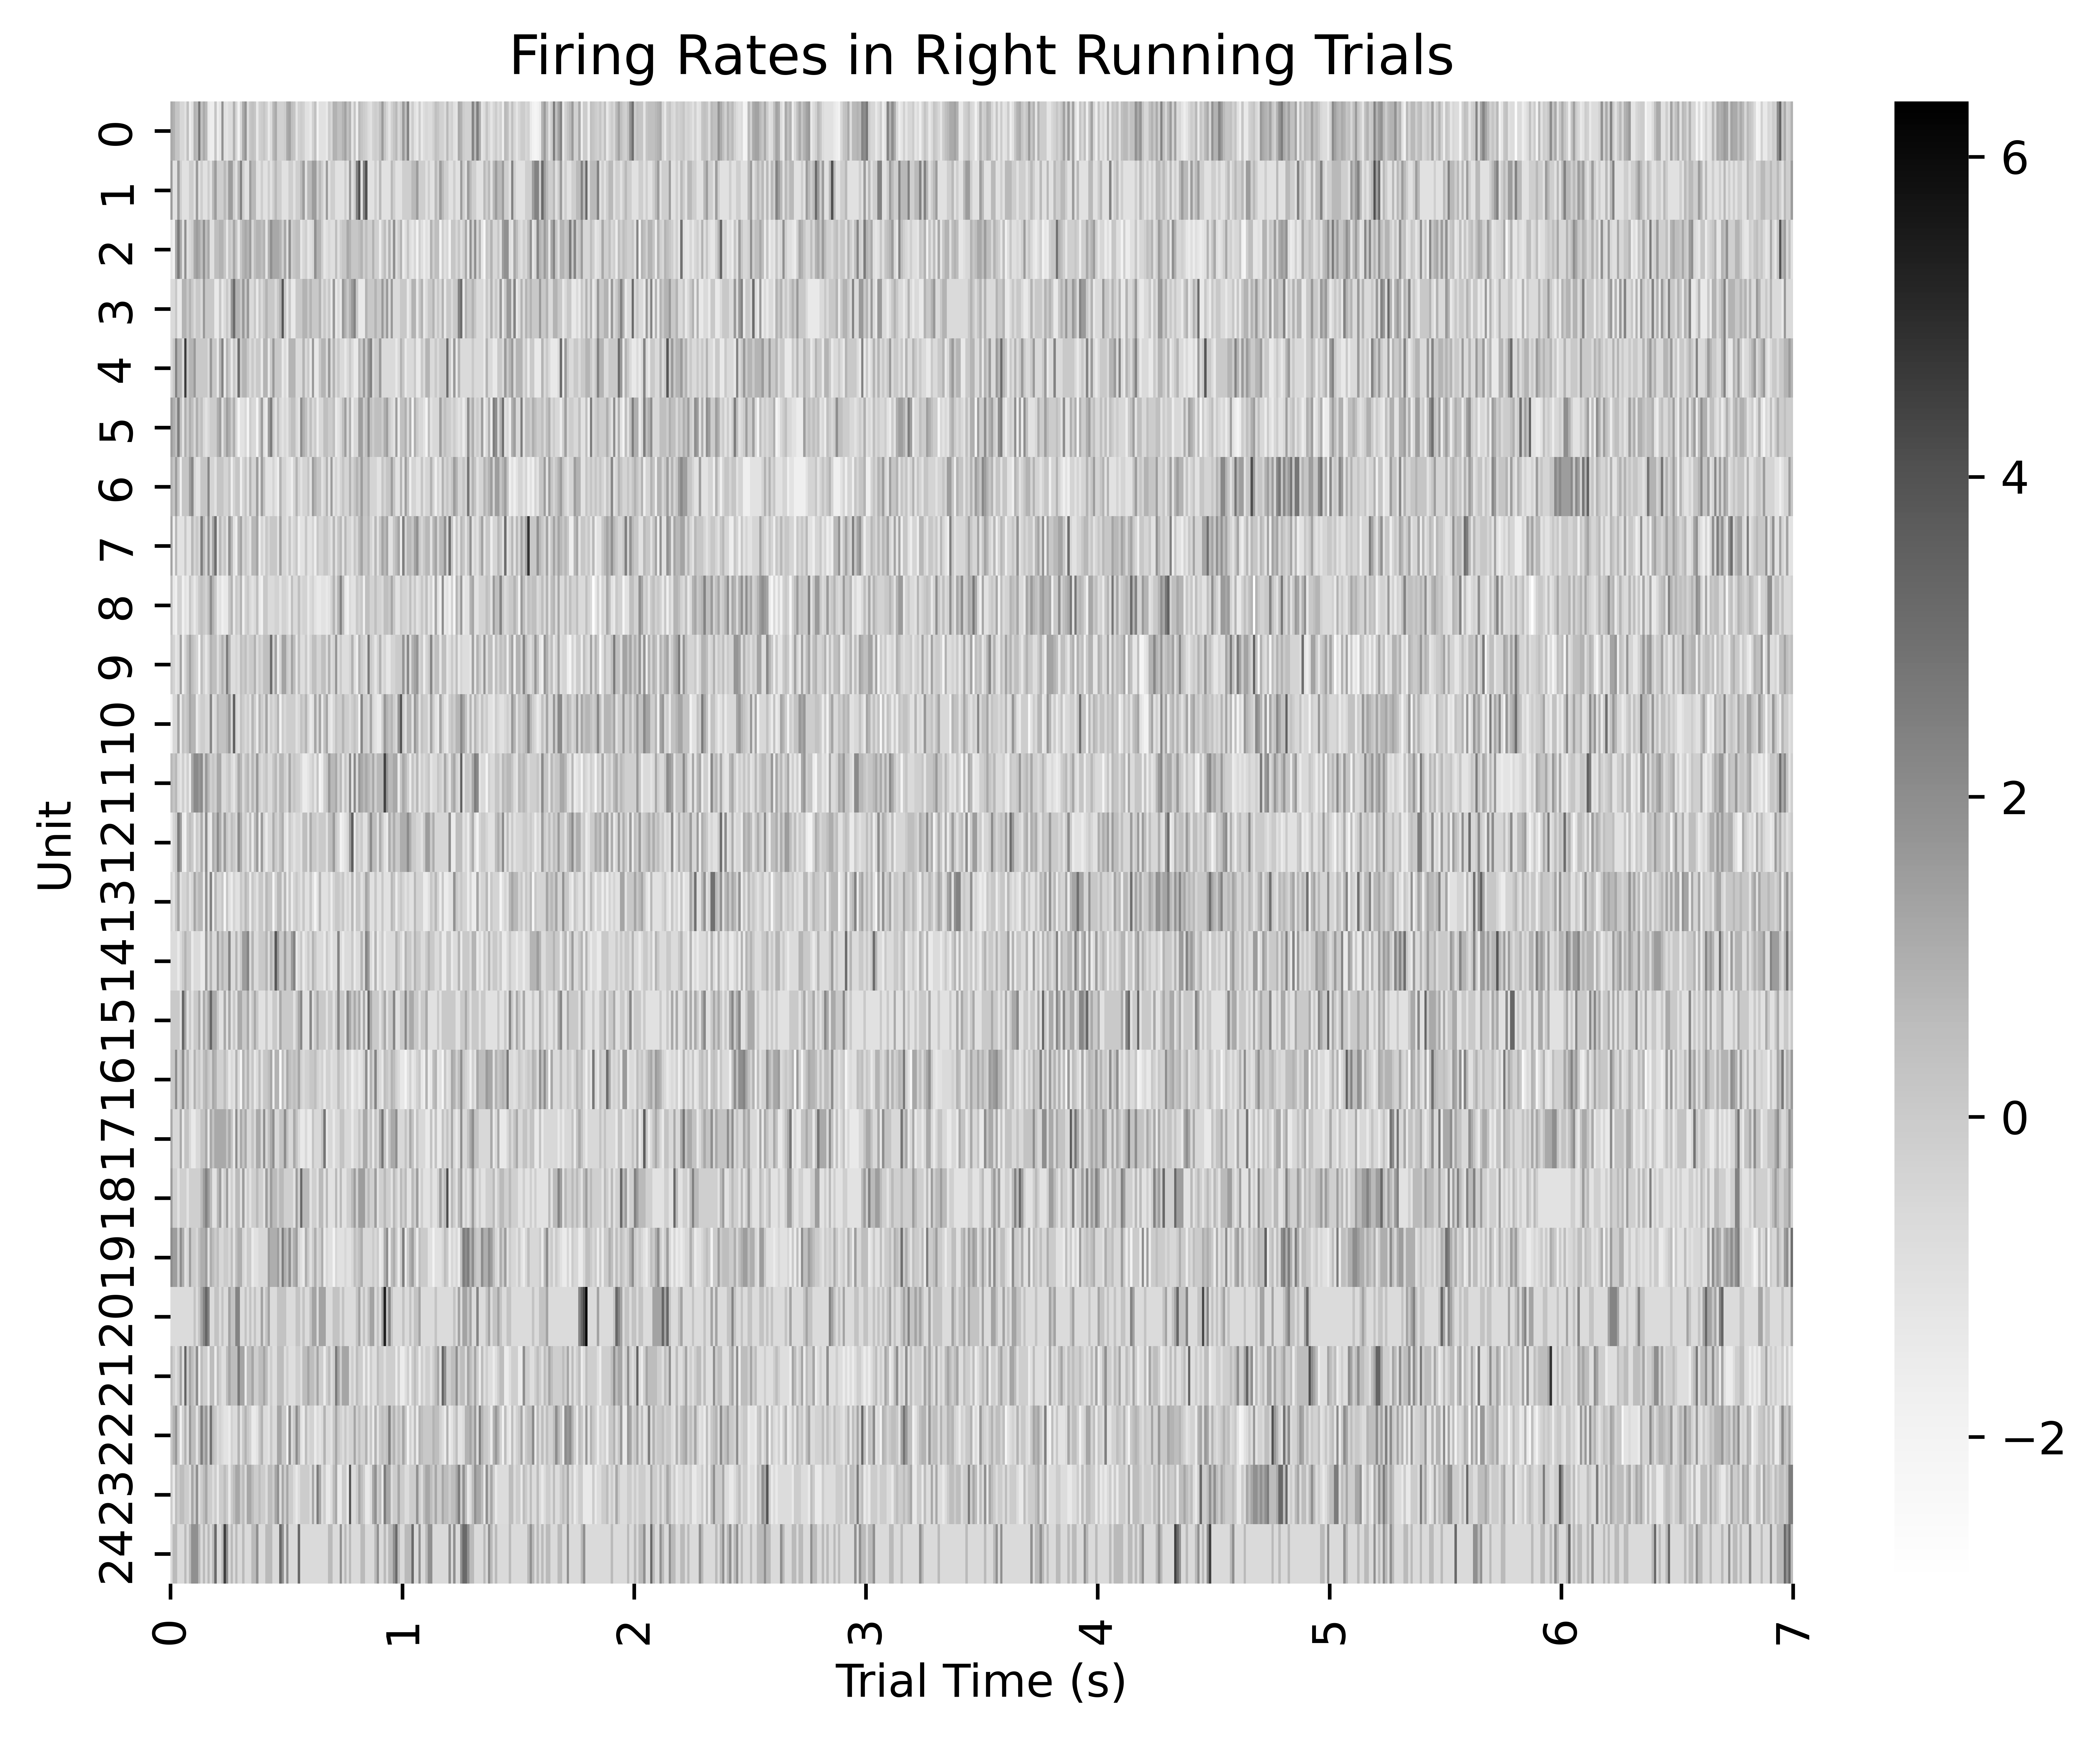

In [133]:
animal_id = 325
unit_id = 325005
time_trial_start = 0 # Seconds
time_trial_end = 7
run_status = 'run' # 'run' or 'still'
run_direction = 'right' # left' or 'right'
binsize = 0.01 # Second

df_now = metrics_filtered
#df_now = df_now.sort_values(by='layer', ascending=False).reset_index()

for i in range(len(df_now)):
    spikes_curr = df_now['spiking_right_local_timing_run'].iloc[i]
    spike_binned, _ = np.histogram(spikes_curr, bins=int(1/binsize*(time_trial_end-time_trial_start)), range=[time_trial_start, time_trial_end])
    if 'spike_2_plot' not in locals():
        spike_2_plot = spike_binned
    else:
        spike_2_plot = np.vstack([spike_2_plot, spike_binned])

spike_2_plot_z_scored = (spike_2_plot - spike_2_plot.mean(axis=1)[:, None]) / spike_2_plot.std(axis=1)[:, None]

fig = plt.figure(figsize=(8, 6), dpi=1200)
ax = plt.subplot()
ax = sns.heatmap(spike_2_plot_z_scored, cmap='Greys')
ax.set_xticks([0, 100, 200, 300, 400, 500, 600, 700])
ax.set_xticklabels([0, 1, 2, 3, 4, 5, 6, 7])
ax.set_xlabel('Trial Time (s)')
ax.set_ylabel('Unit')
#ax.set_yticks([0, 40])
#ax.set_yticklabels(['Upper', 'Lower'])
ax.set_title('Firing Rates in Right Running Trials')

del(spike_2_plot)

In [96]:
metrics_filtered['cluster_id_global'].values

array([325018, 325019, 325024, 325025, 325035, 325040, 325043, 325046,
       325054, 325055, 325056, 325057, 325060, 325062, 325072, 325074,
       325075, 325080, 325083, 325092, 325105, 325118, 325121, 325184,
       325189], dtype=int64)

In [ ]:
good_list = [325097]
okay_list = [325046, 325080]

In [134]:
unit_id = 325097

trials_filtered = trials_behavior_still_or_run[(trials_behavior_still_or_run['status'] == run_status) & (trials_behavior_still_or_run['trial_type'] == run_direction) & (trials_behavior_still_or_run['animal'] == animal_id)]['global_trial']

beh_trials_unfiltered_temp = beh_trials_unfiltered[beh_trials_unfiltered['global_trial'].isin(trials_filtered)]
list_start = beh_trials_unfiltered_temp['t0_global_time_ephys_file'] + time_trial_start
list_end = beh_trials_unfiltered_temp['t0_global_time_ephys_file'] + time_trial_end

to_plot = spikes[np.where(spikes[:, 0] == unit_id)][:, 1]
plot_matrix = np.empty((len(list_start), 1000))
plot_matrix[:] = -2

for i in range(len(list_start)):
    t_start = list_start.iloc[i]
    t_end = list_end.iloc[i]
    to_plot_curr = to_plot[np.where((to_plot < t_end) & (to_plot > t_start))] - t_start + time_trial_start
    plot_matrix[i, 0:len(to_plot_curr)] = to_plot_curr

plot_matrix = plot_matrix[np.where(plot_matrix.mean(axis=1) != -2)]

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, gridspec_kw={'height_ratios': [4, 1]}, sharex=True, figsize=(8, 6), dpi=1200)

ax1.eventplot(plot_matrix, linewidths=1, linelength=1, colors='k')
ax1.set_xlim(time_trial_start, time_trial_end)
ax1.axvline(x=0, color='black', linestyle='--')
ax1.set_ylabel("Trial")

hist_2_plot, _ = np.histogram(plot_matrix, bins=int(1/binsize*(time_trial_end-time_trial_start)), range=[time_trial_start, time_trial_end])

ax2.plot(np.arange(time_trial_start, time_trial_end, binsize), hist_2_plot)
ax2.set_ylabel("Number of Spikes")
ax2.set_xlabel("Local Time (s)")
fig.tight_layout()
